In [1]:
using CairoMakie, QuantEcon, LinearAlgebra, Optim, Dierckx, QuadGK

In [2]:
include("crra_code.jl")
include("ces_code.jl")

hpi_CES (generic function with 1 method)

In [18]:
pars_crra = (;A = 0.01, # total factor productivity
    α = 0.33, # capital share
    δ = 0.08, # depreciation rate
    r = 0.0, # interest rate
    rnew = 0.05, # Set to 0.05 for γ = 2.0, set to 0.1 for γ = 1.0
    w = 1.0, # wage
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 101, # number of asset grid points
    ϕ = 0.0, # borrowing constraint
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    print_skip = 1000, # how often to print
    how_iter = 50, # number of Howard iterations
    toler_prices = 1e-3, # tolerance
    maxiter_prices = 100, # maximum no. of iterations
    print_skip_prices = 1, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 1000.0) # upper bound of capital grid

(A = 0.01, α = 0.33, δ = 0.08, r = 0.0, rnew = 0.05, w = 1.0, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 101, ϕ = 0.0, θ = 4.0, toler = 4.0e-7, maxiter = 1000, print_skip = 1000, how_iter = 50, toler_prices = 0.001, maxiter_prices = 100, print_skip_prices = 1, lb = 0.0, ub = 1000.0)

In [19]:
function invariant_distribution(M, O, X, Y, Inv, policy, Π, Avals, n, pars)
    (; na, nz) = pars
    for i in 1:na
        for j in 1:nz
            if policy[i,j] <+ Avals[1]
                M[i,j,1,:] = Π[j,:]
            elseif policy[i,j] >= Avals[end]
                M[i,j,end,:] = Π[j,:]
            else
                index = findfirst(x -> x > policy[i,j], Avals)
                π = (Avals[index] - policy[i,j]) / (Avals[index] - Avals[index-1])
                M[i,j,index-1,:] = π * Π[j,:]
                M[i,j,index,:] = (1-π) * Π[j,:]
            end
        end
    end
    O = reshape(M, n, n)
    for i in 1:na
        O[i,:] = O[i,:] / sum(O[i,:])
    end
    X = reduce(vcat, [I(n) - O', ones(1,n)])
    Y = [zeros(n);1]
    Inv = X \ Y
    Inv[Inv .< 0] .= 0
    Inv = Inv / sum(Inv)
    return Inv
end

invariant_distribution (generic function with 1 method)

In [20]:
function labour_supply(Π, Zvals, pars)
    (; nz) = pars
    L = zeros(nz)
    L2 = reduce(vcat, [I(nz) - Π', ones(1,nz)])
    L3 = [zeros(nz);1]
    L = L2 \ L3
    L[L .< 0] .= 0
    L = L / sum(L)
    L = L' * Zvals
    return L
end

labour_supply (generic function with 1 method)

Iterating on prices...
////////////////////
Price Iteration: 0
Iterating...
--------------------
Iteration: 0, Error: 0.9995961252550947
--------------------
Converged in 172 iterations for r = 0.025 and w = 0.018340836716457993
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 0, Ks = 0.05972423847114112, Kd = 0.06344642249526665, diff = -0.0037221840241255313
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 1
Iterating...
--------------------
Iteration: 0, Error: 0.030790708462665815
--------------------
Converged in 132 iterations for r = 0.037500000000000006 and w = 0.017672545854601797
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 1, Ks = 0.06176300116572068, Kd = 0.05669680308087658, diff = 0.005066198084844098
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 2
Iterating...
--------------------
Iteration: 0, Error: 0.015271800591840119
--------------------
Converged in 126 iterations for r = 0.03125 and w = 0.017994202629576402
--------------------
%%%%%%%%%

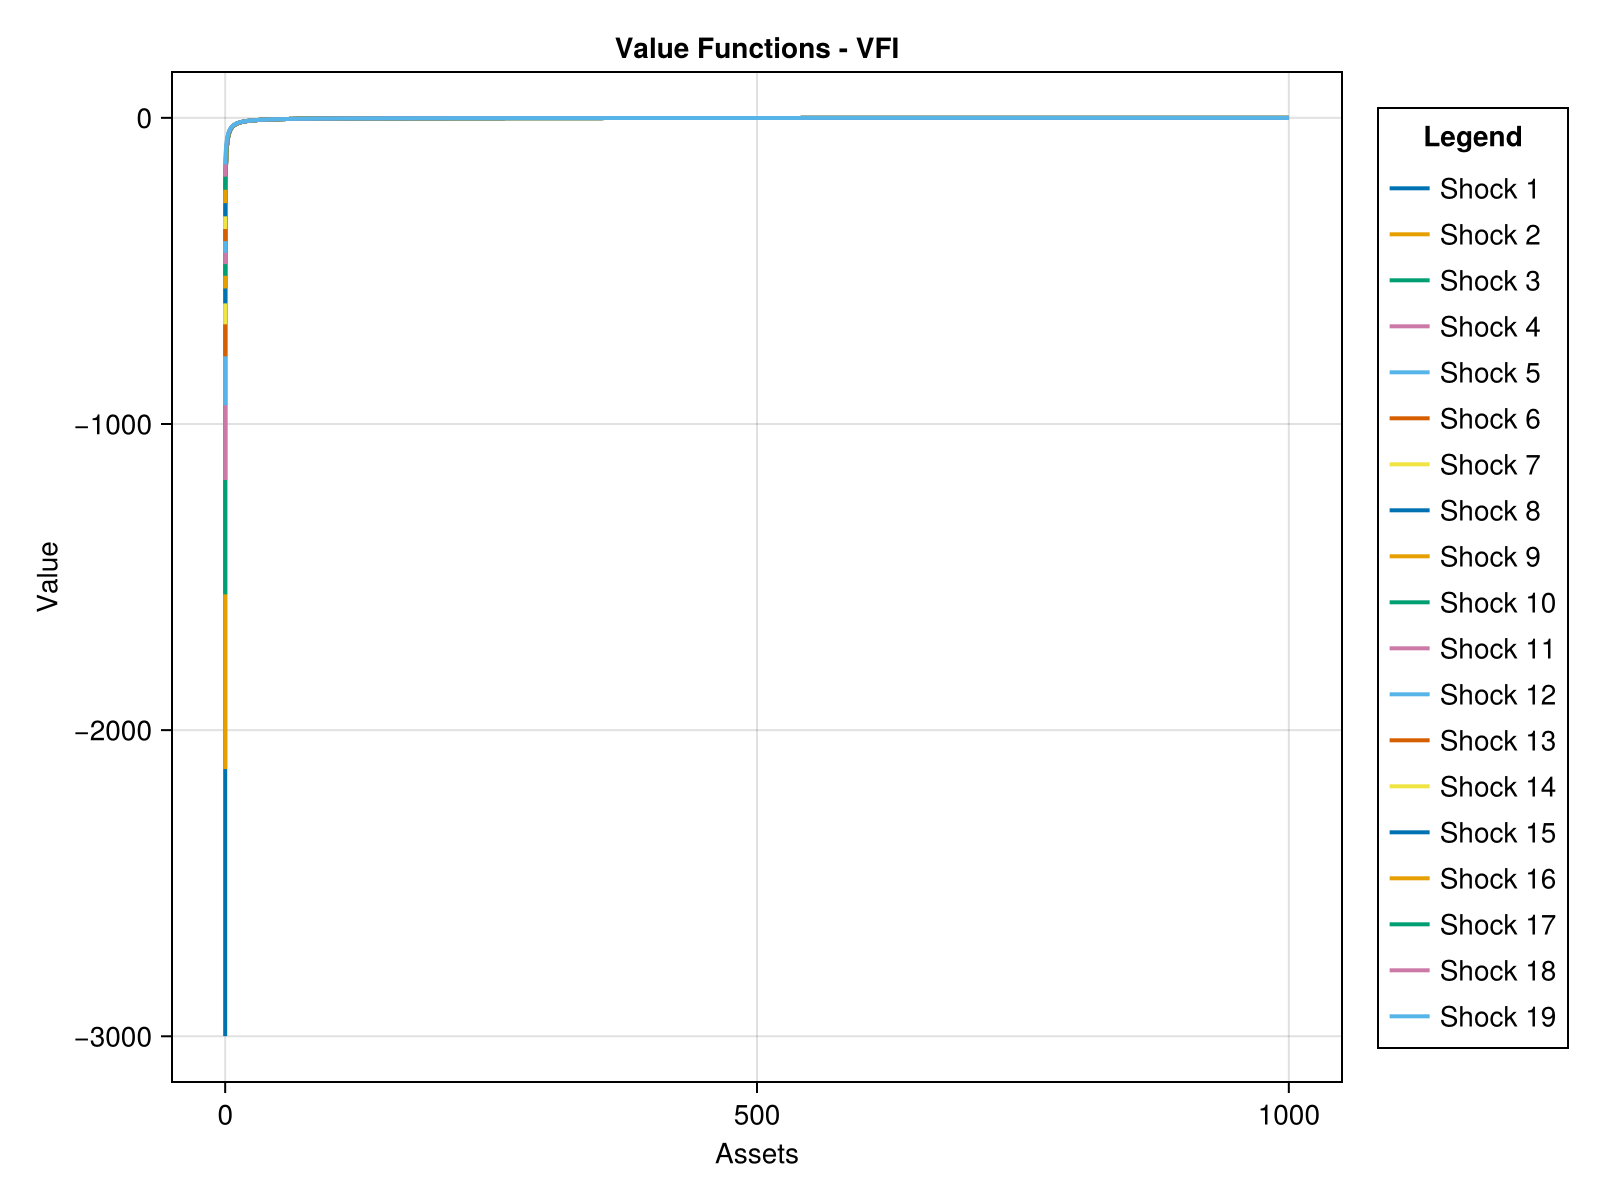

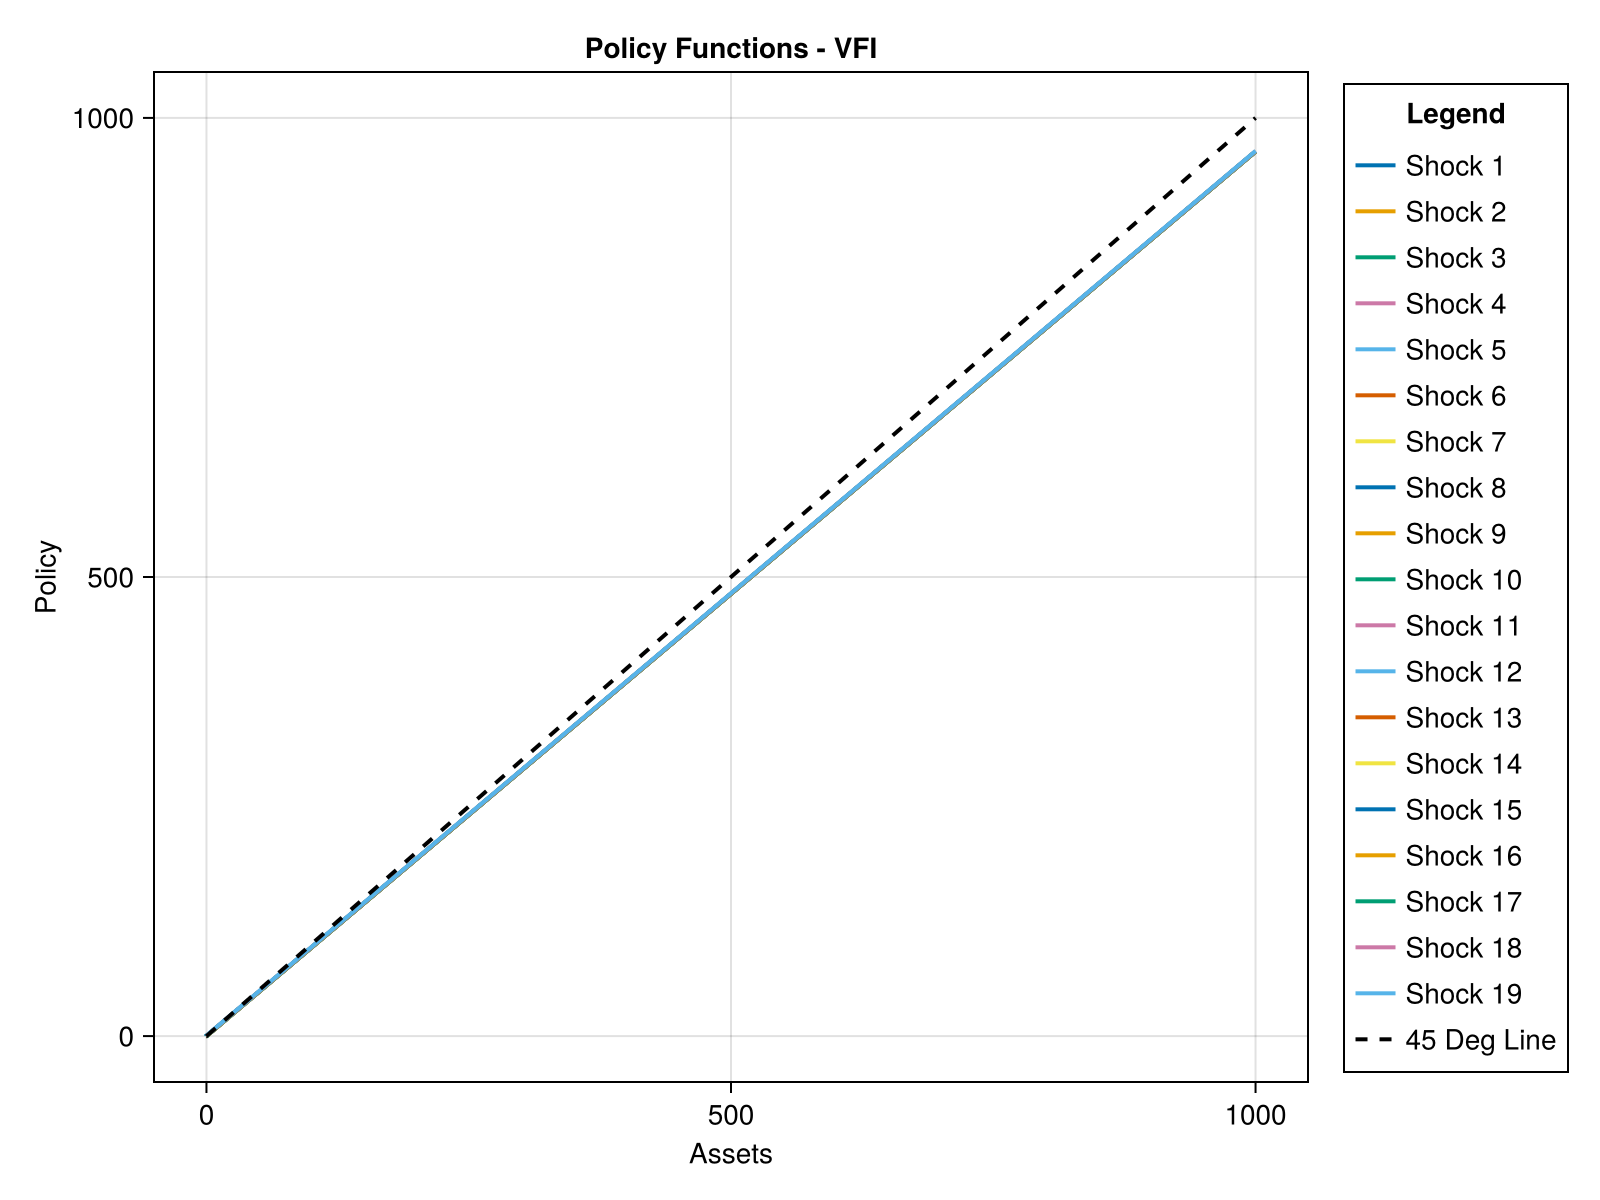

In [21]:
function equilibrium_vfi_crra(pars)
    (; na, nz, toler_prices, maxiter_prices, print_skip_prices, r, w, β, A, α, ϕ, δ, rnew) = pars
    n = na * nz
    M = zeros(na, nz, na, nz)
    O = zeros(n, n)
    X = zeros(n+1,n)
    Y = zeros(n+1)
    Inv = zeros(n)
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_init = zeros(na,nz)
    policy = similar(v_init)
    wealth = zeros(na,nz)
    L = labour_supply(Π, Zvals, pars)
    Ks, Kd = 1, 1
    iter = 0
    error = toler_prices + 1
    if iter == 0
        println("Iterating on prices...")
    end
    while ((error > toler_prices) && (iter < maxiter_prices))
        println("////////////////////")
        println("Price Iteration: $iter")
        r_iter = (r + rnew) / 2
        Kd = ((A^α * L ^ (1-α)) / (r_iter + δ))^1/(1-α)
        w_iter = (1-α) * A * (Kd/L)^α
        Φ = w_iter * (exp(minimum(Zvals))/r_iter)
        if ϕ > 0
            ϕ_iter = min(Φ, exp(minimum(Zvals)))
            pars = (; pars..., ϕ = ϕ_iter, r = r_iter, w = w_iter)
        else
            pars = (; pars..., r = r_iter, w = w_iter)
        end
        v_new, policy = vfi(v_init, policy, Π, Zvals, Avals, pars)
        Invariant = invariant_distribution(M, O, X, Y, Inv, policy, Π, Avals, n, pars)
        G = reshape(policy .- ϕ, n, 1)
        Ks = dot(Invariant', G)
        diff = Ks - Kd
        error = abs(diff)
        if diff > 0
            rnew = r_iter
        else
            r = r_iter
        end
        if iter % print_skip_prices == 0
            println("%%%%%%%%%%%%%%%%%%%%")
            println("Iter = $iter, Ks = $Ks, Kd = $Kd, diff = $diff")
            println("%%%%%%%%%%%%%%%%%%%%")
        end
        v_init .= v_new
        iter += 1
    end
    r_final = r + rnew / 2
    w_final = (1-α) * A * (Kd/L)^α
    Invariant = reshape(Invariant, na, nz)
    for i in 1:na
        for j in 1:nz
            wealth[i,j] = w_final * exp(Zvals[j]) + (1 + r_final) * Avals[i]
        end
    end
    println("%%%%%%%%%%%%%%%%%%%%")
    println("r = $r_final, w = $w_final")
    println("%%%%%%%%%%%%%%%%%%%%")
    return v_init, policy, Invariant, wealth
end

@time begin 
    v_vfi_crra, pol_vfi_crra, dist_vfi_crra, wealth_vfi_crra = equilibrium_vfi_crra(pars_crra)
end

fig1 = Figure(size = (800, 600))
ax1 = Axis(fig1[1, 1], xlabel = "Assets", ylabel = "Value", title = "Value Functions - VFI")
for j in 1:pars_crra.nz
    lines!(ax1, exp_grid(pars_crra), v_vfi_crra[:,j], linewidth = 2, label = "Shock $j")
end
legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
display(fig1)

fig2 = Figure(size = (800, 600))
ax2 = Axis(fig2[1, 1], xlabel = "Assets", ylabel = "Policy", title = "Policy Functions - VFI")
for j in 1:pars_crra.nz
    lines!(ax2, exp_grid(pars_crra), pol_vfi_crra[:,j], linewidth = 2, label = "Shock $j")
end
lines!(ax2, exp_grid(pars_crra), exp_grid(pars_crra), color = :black, linewidth = 2, label = "45 Deg Line", linestyle = :dash)
legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
fig2

Iterating on prices...
////////////////////
Price Iteration: 0
Iterating...
--------------------
Iteration: 0, Error: 0.9997094187171872
--------------------
Converged in 41 iterations for r = 0.05 and w = 0.017092685700304328
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 0, Ks = 0.07263759564406923, Kd = 0.05124518740002307, diff = 0.02139240824404616
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 1
Iterating...
--------------------
Iteration: 0, Error: 0.26799350267013305
--------------------
Converged in 4 iterations for r = 0.025 and w = 0.018340836716457993
--------------------
%%%%%%%%%%%%%%%%%%%%
Iter = 1, Ks = 0.055691142190518, Kd = 0.06344642249526665, diff = -0.007755280304748646
%%%%%%%%%%%%%%%%%%%%
////////////////////
Price Iteration: 2
Iterating...
--------------------
Iteration: 0, Error: 0.1618298181260424
--------------------
Converged in 4 iterations for r = 0.037500000000000006 and w = 0.017672545854601797
--------------------
%%%%%%%%%%%%%%%%%%%%
Ite

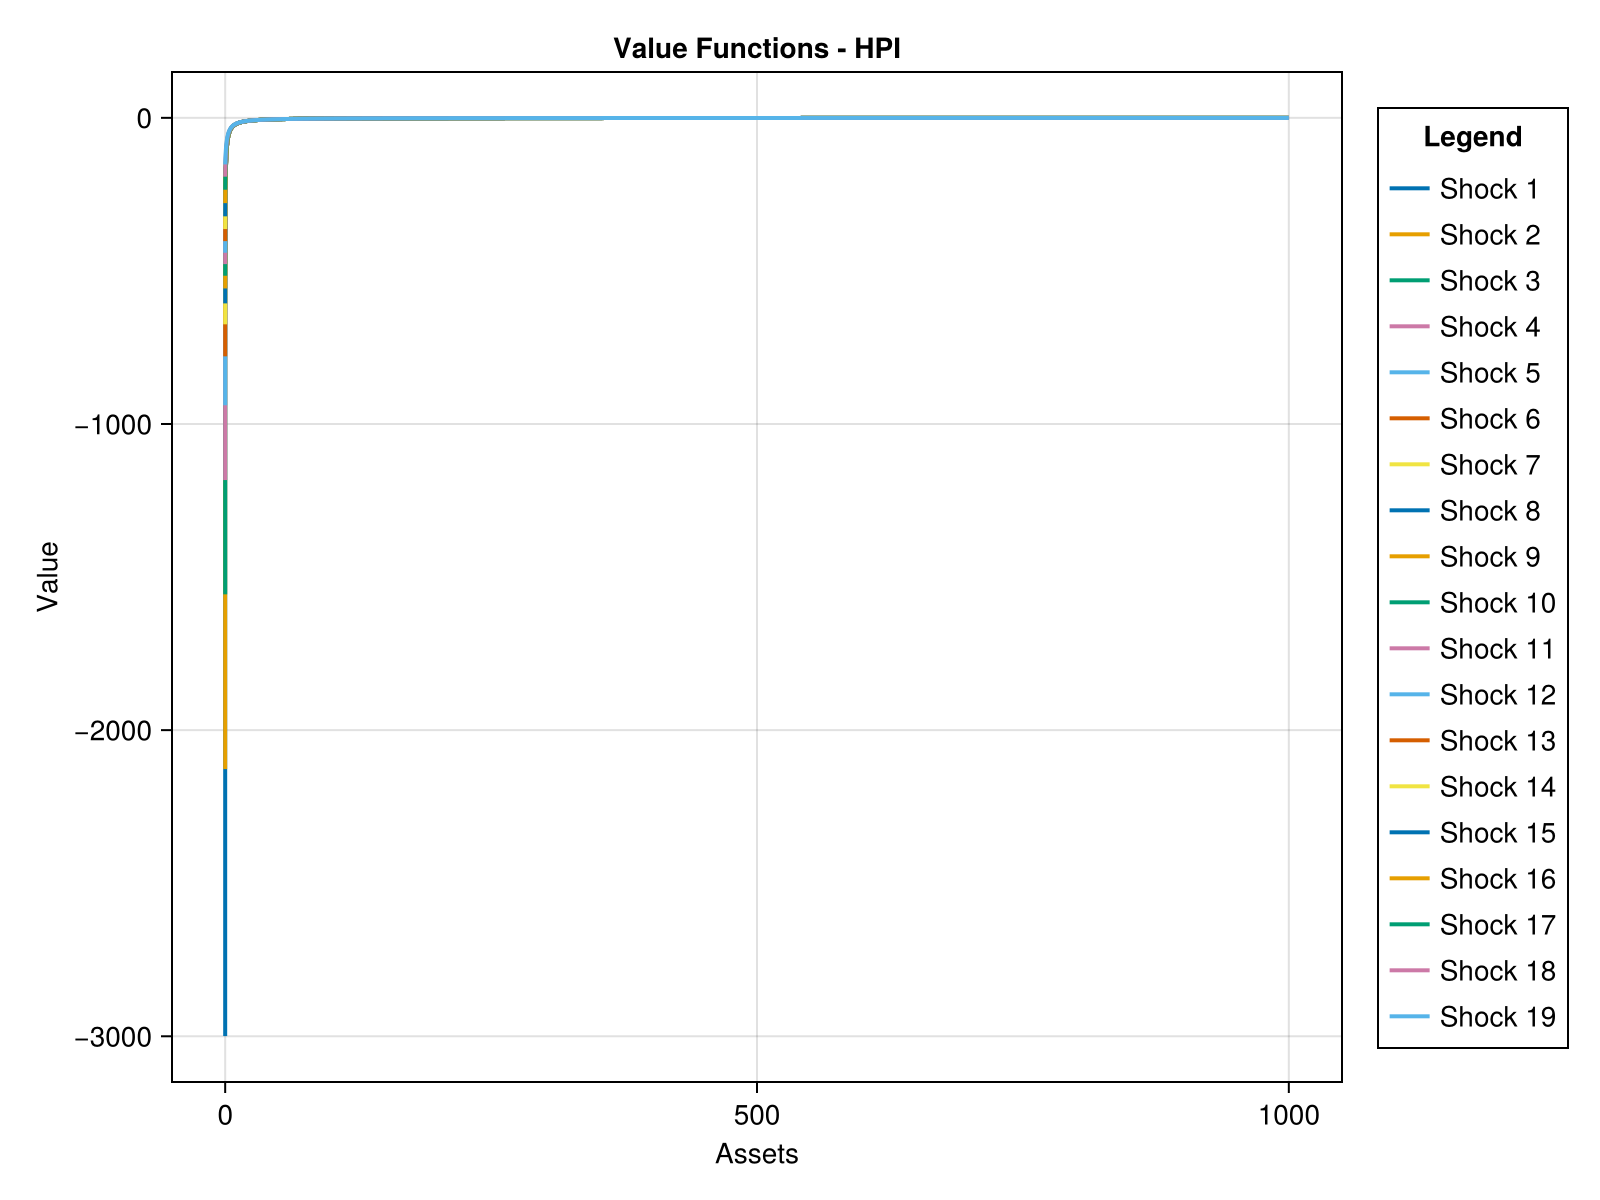

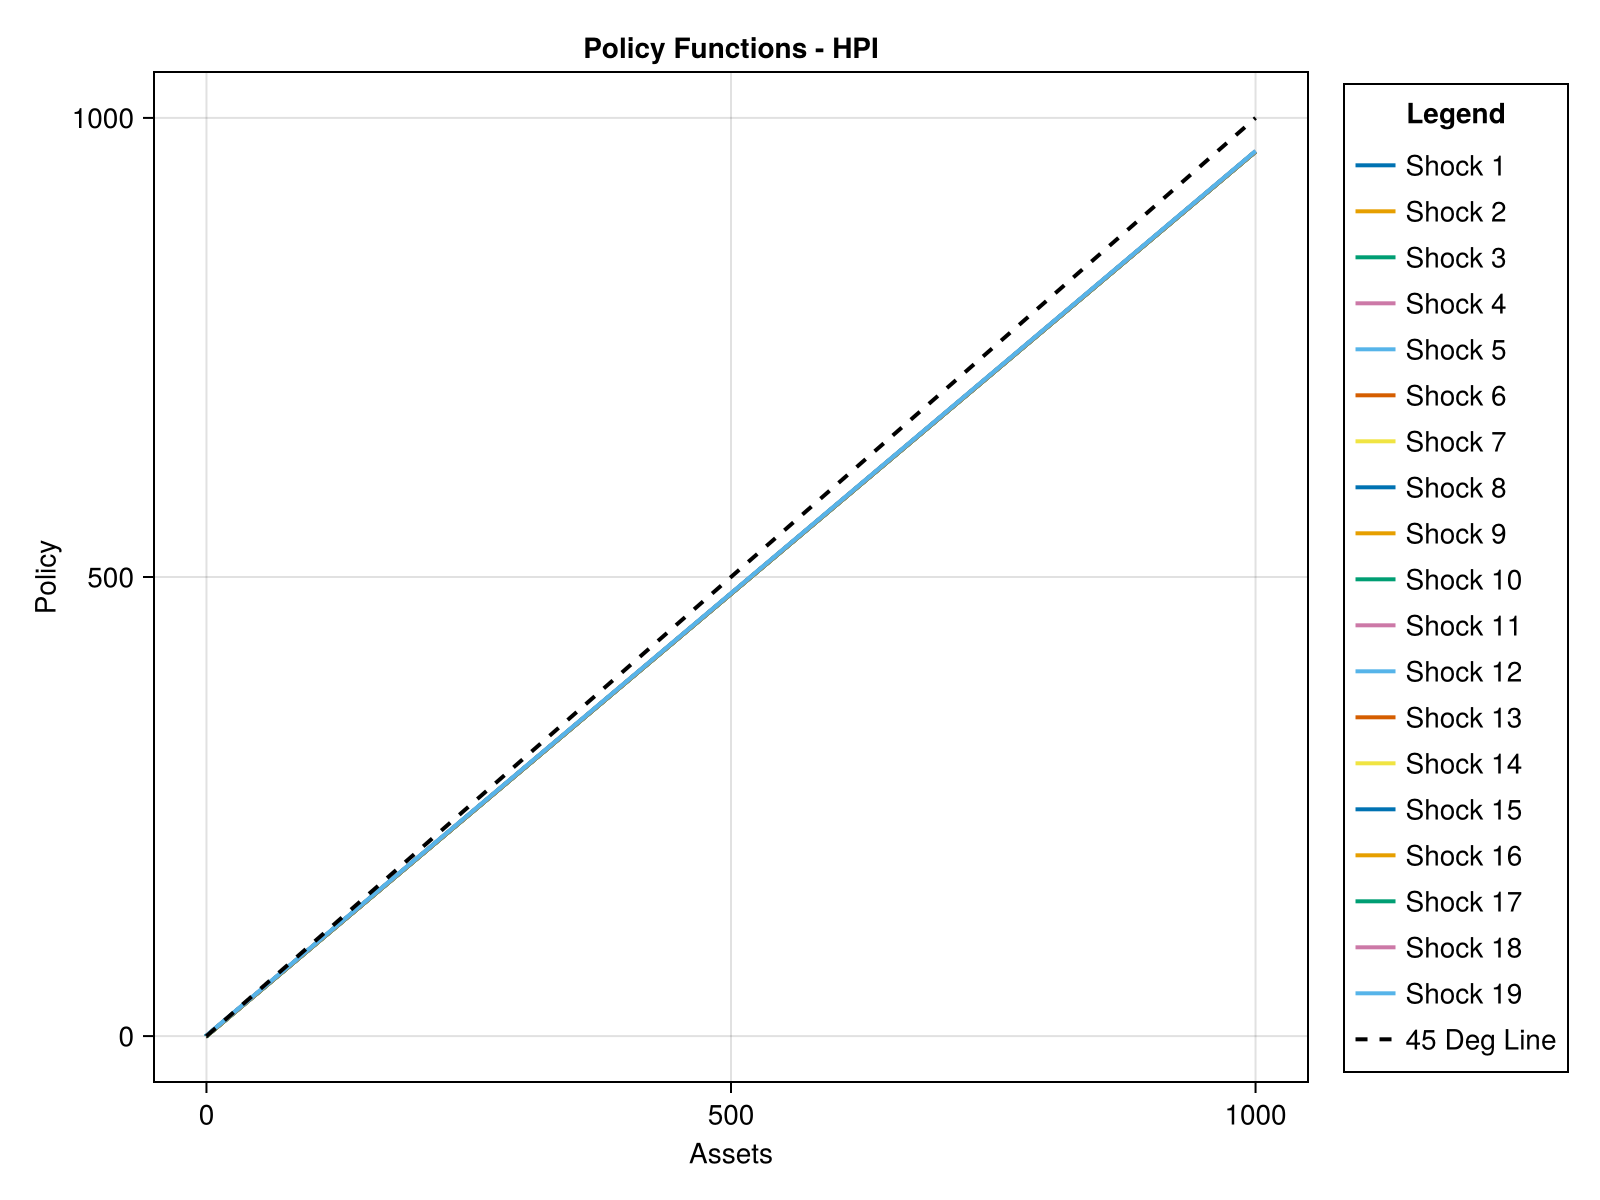

In [22]:
function equilibrium_hpi_crra(pars)
    (; na, nz, toler_prices, maxiter_prices, print_skip_prices, r, w, β, A, α, ϕ, δ) = pars
    n = na * nz
    M = zeros(na, nz, na, nz)
    O = zeros(n, n)
    X = zeros(n+1,n)
    Y = zeros(n+1)
    Inv = zeros(n)
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_init = zeros(na,nz)
    policy = similar(v_init)
    wealth = zeros(na,nz)
    L = labour_supply(Π, Zvals, pars)
    Ks, Kd = 1, 1
    iter = 0
    error = toler_prices + 1
    rnew = 0.1 # Set to 0.05 for γ = 2.0, set to 0.1 for γ = 1.0
    if iter == 0
        println("Iterating on prices...")
    end
    while ((error > toler_prices) && (iter < maxiter_prices))
        println("////////////////////")
        println("Price Iteration: $iter")
        r_iter = (r + rnew) / 2
        Kd = ((A^α * L ^ (1-α)) / (r_iter + δ))^1/(1-α)
        w_iter = (1-α) * A * (Kd/L)^α
        Φ = w_iter * (exp(minimum(Zvals))/r_iter)
        if ϕ > 0
            ϕ_iter = min(Φ, exp(minimum(Zvals)))
            pars = (; pars..., ϕ = ϕ_iter, r = r_iter, w = w_iter)
        else
            pars = (; pars..., r = r_iter, w = w_iter)
        end
        v_new, policy = hpi(v_init, policy, Π, Zvals, Avals, pars)
        Invariant = invariant_distribution(M, O, X, Y, Inv, policy, Π, Avals, n, pars)
        G = reshape(policy .- ϕ, n, 1)
        Ks = dot(Invariant', G)
        diff = Ks - Kd
        error = abs(diff)
        if diff > 0
            rnew = r_iter
        else
            r = r_iter
        end
        if iter % print_skip_prices == 0
            println("%%%%%%%%%%%%%%%%%%%%")
            println("Iter = $iter, Ks = $Ks, Kd = $Kd, diff = $diff")
            println("%%%%%%%%%%%%%%%%%%%%")
        end
        v_init .= v_new
        iter += 1
    end
    r_final = r + rnew / 2
    w_final = (1-α) * A * (Kd/L)^α
    Invariant = reshape(Invariant, na, nz)
    for i in 1:na
        for j in 1:nz
            wealth[i,j] = w_final * exp(Zvals[j]) + (1 + r_final) * Avals[i]
        end
    end
    println("%%%%%%%%%%%%%%%%%%%%")
    println("r = $r_final, w = $w_final")
    println("%%%%%%%%%%%%%%%%%%%%")
    return v_init, policy, Invariant, wealth
end

@time begin 
    v_hpi_crra, pol_hpi_crra, dist_hpi_crra, wealth_hpi_crra = equilibrium_hpi_crra(pars_crra)
end

fig1 = Figure(size = (800, 600))
ax1 = Axis(fig1[1, 1], xlabel = "Assets", ylabel = "Value", title = "Value Functions - HPI")
for j in 1:pars_crra.nz
    lines!(ax1, exp_grid(pars_crra), v_hpi_crra[:,j], linewidth = 2, label = "Shock $j")
end
legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
display(fig1)

fig2 = Figure(size = (800, 600))
ax2 = Axis(fig2[1, 1], xlabel = "Assets", ylabel = "Policy", title = "Policy Functions - HPI")
for j in 1:pars_crra.nz
    lines!(ax2, exp_grid(pars_crra), pol_hpi_crra[:,j], linewidth = 2, label = "Shock $j")
end
lines!(ax2, exp_grid(pars_crra), exp_grid(pars_crra), color = :black, linewidth = 2, label = "45 Deg Line", linestyle = :dash)
legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
fig2

In [8]:
pars_ces = (;A = 0.01, # total factor productivity
    α = 0.33, # capital share
    δ = 0.08, # depreciation rate
    r = 0.00, # interest rate
    w = 1.0, # wage
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion (recall that this must be greater than 1 in the CES formulation)
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 501, # number of asset grid points
    ϕ = 0.0, # borrowing constraint
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    print_skip = 1000, # how often to print
    how_iter = 50, # number of Howard iterations
    dampened_howard = false, # whether to dampen Howard improvement step
    ϵ = 0.1, # factor by which to dampen Howard improvement step
    toler_prices = 1e-3, # tolerance
    maxiter_prices = 100, # maximum no. of iterations
    print_skip_prices = 1, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 100000000.0) # upper bound of capital grid

(A = 0.01, α = 0.33, δ = 0.08, r = 0.0, w = 1.0, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 501, ϕ = 0.0, θ = 4.0, toler = 4.0e-7, maxiter = 1000, print_skip = 1000, how_iter = 50, dampened_howard = false, ϵ = 0.1, toler_prices = 0.001, maxiter_prices = 100, print_skip_prices = 1, lb = 0.0, ub = 1.0e8)

In [9]:
function equilibrium_vfi_CES(pars)
    (; na, nz, toler_prices, maxiter_prices, print_skip_prices, r, w, β, A, α, ϕ, δ) = pars
    n = na * nz
    M = zeros(na, nz, na, nz)
    O = zeros(n, n)
    X = zeros(n+1,n)
    Y = zeros(n+1)
    Inv = zeros(n)
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_init = zeros(na,nz)
    policy = similar(v_init)
    wealth = zeros(na,nz)
    L = labour_supply(Π, Zvals, pars)
    Ks, Kd = 1, 1
    iter = 0
    error = toler_prices + 1
    rnew = 1.0
    if iter == 0
        println("Iterating on prices...")
    end
    while ((error > toler_prices) && (iter < maxiter_prices))
        println("////////////////////")
        println("Price Iteration: $iter")
        r_iter = (r + rnew) / 2
        Kd = ((A^α * L ^ (1-α)) / (r_iter + δ))^1/(1-α)
        w_iter = (1-α) * A * (Kd/L)^α
        Φ = w_iter * (exp(minimum(Zvals))/r_iter)
        if ϕ > 0
            ϕ_iter = min(Φ, exp(minimum(Zvals)))
            pars = (; pars..., ϕ = ϕ_iter, r = r_iter, w = w_iter)
        else
            pars = (; pars..., r = r_iter, w = w_iter)
        end
        v_new, policy = vfi_CES(v_init, policy, Π, Zvals, Avals, pars)
        Invariant = invariant_distribution(M, O, X, Y, Inv, policy, Π, Avals, n, pars)
        G = reshape(policy .- ϕ, n, 1)
        Ks = dot(Invariant', G)
        diff = Ks - Kd
        error = abs(diff)
        if diff > 0
            rnew = r_iter
        else
            r = r_iter
        end
        if iter % print_skip_prices == 0
            println("%%%%%%%%%%%%%%%%%%%%")
            println("Iter = $iter, Ks = $Ks, Kd = $Kd, diff = $diff")
            println("%%%%%%%%%%%%%%%%%%%%")
        end
        v_init .= v_new
        iter += 1
    end
    r_final = r + rnew / 2
    w_final = (1-α) * A * (Kd/L)^α
    Invariant = reshape(Invariant, na, nz)
    for i in 1:na
        for j in 1:nz
            wealth[i,j] = w_final * exp(Zvals[j]) + (1 + r_final) * Avals[i]
        end
    end
    println("%%%%%%%%%%%%%%%%%%%%")
    println("r = $r_final, w = $w_final")
    println("%%%%%%%%%%%%%%%%%%%%")
    return v_init, policy, Invariant, wealth
end

@time begin 
    v_vfi_ces, pol_vfi_ces, dist_vfi_ces, wealth_vfi_ces = equilibrium_vfi_CES(pars_ces)
end

Iterating on prices...
////////////////////
Price Iteration: 0
Iterating...
--------------------
Iteration: 0, Error: 0.0
--------------------
Converged in 1 iterations for r = 0.5 and w = 0.010434709797624078
--------------------


In [1]:
function equilibrium_hpi_CES(pars)
    (; na, nz, toler_prices, maxiter_prices, print_skip_prices, r, w, β, A, α, ϕ, δ) = pars
    n = na * nz
    M = zeros(na, nz, na, nz)
    O = zeros(n, n)
    X = zeros(n+1,n)
    Y = zeros(n+1)
    Inv = zeros(n)
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_init = zeros(na,nz)
    policy = similar(v_init)
    wealth = zeros(na,nz)
    L = labour_supply(Π, Zvals, pars)
    Ks, Kd = 1, 1
    iter = 0
    error = toler_prices + 1
    rnew = 1/β - 1
    if iter == 0
        println("Iterating on prices...")
    end
    while ((error > toler_prices) && (iter < maxiter_prices))
        println("////////////////////")
        println("Price Iteration: $iter")
        r_iter = (r + rnew) / 2
        Kd = ((A^α * L ^ (1-α)) / (r_iter + δ))^1/(1-α)
        w_iter = (1-α) * A * (Kd/L)^α
        Φ = w_iter * (exp(minimum(Zvals))/r_iter)
        if ϕ > 0
            ϕ_iter = min(Φ, exp(minimum(Zvals)))
            pars = (; pars..., ϕ = ϕ_iter, r = r_iter, w = w_iter)
        else
            pars = (; pars..., r = r_iter, w = w_iter)
        end
        v_new, policy = hpi_CES(v_init, policy, Π, Zvals, Avals, pars)
        Invariant = invariant_distribution(M, O, X, Y, Inv, policy, Π, Avals, n, pars)
        G = reshape(policy .- ϕ, n, 1)
        Ks = dot(Invariant', G)
        diff = Ks - Kd
        error = abs(diff)
        if diff > 0
            rnew = r_iter
        else
            r = r_iter
        end
        if iter % print_skip_prices == 0
            println("%%%%%%%%%%%%%%%%%%%%")
            println("Iter = $iter, Ks = $Ks, Kd = $Kd, diff = $diff")
            println("%%%%%%%%%%%%%%%%%%%%")
        end
        v_init .= v_new
        iter += 1
    end
    r_final = r + rnew / 2
    w_final = (1-α) * A * (Kd/L)^α
    Invariant = reshape(Invariant, na, nz)
    for i in 1:na
        for j in 1:nz
            wealth[i,j] = w_final * exp(Zvals[j]) + (1 + r_final) * Avals[i]
        end
    end
    println("%%%%%%%%%%%%%%%%%%%%")
    println("r = $r_final, w = $w_final")
    println("%%%%%%%%%%%%%%%%%%%%")
    return v_init, policy, Invariant, wealth
end

@time begin 
    v_hpi_ces, pol_hpi_ces, dist_hpi_ces, wealth_hpi_ces = equilibrium_hpi_CES(pars_ces)
end

UndefVarError: UndefVarError: `pars_ces` not defined

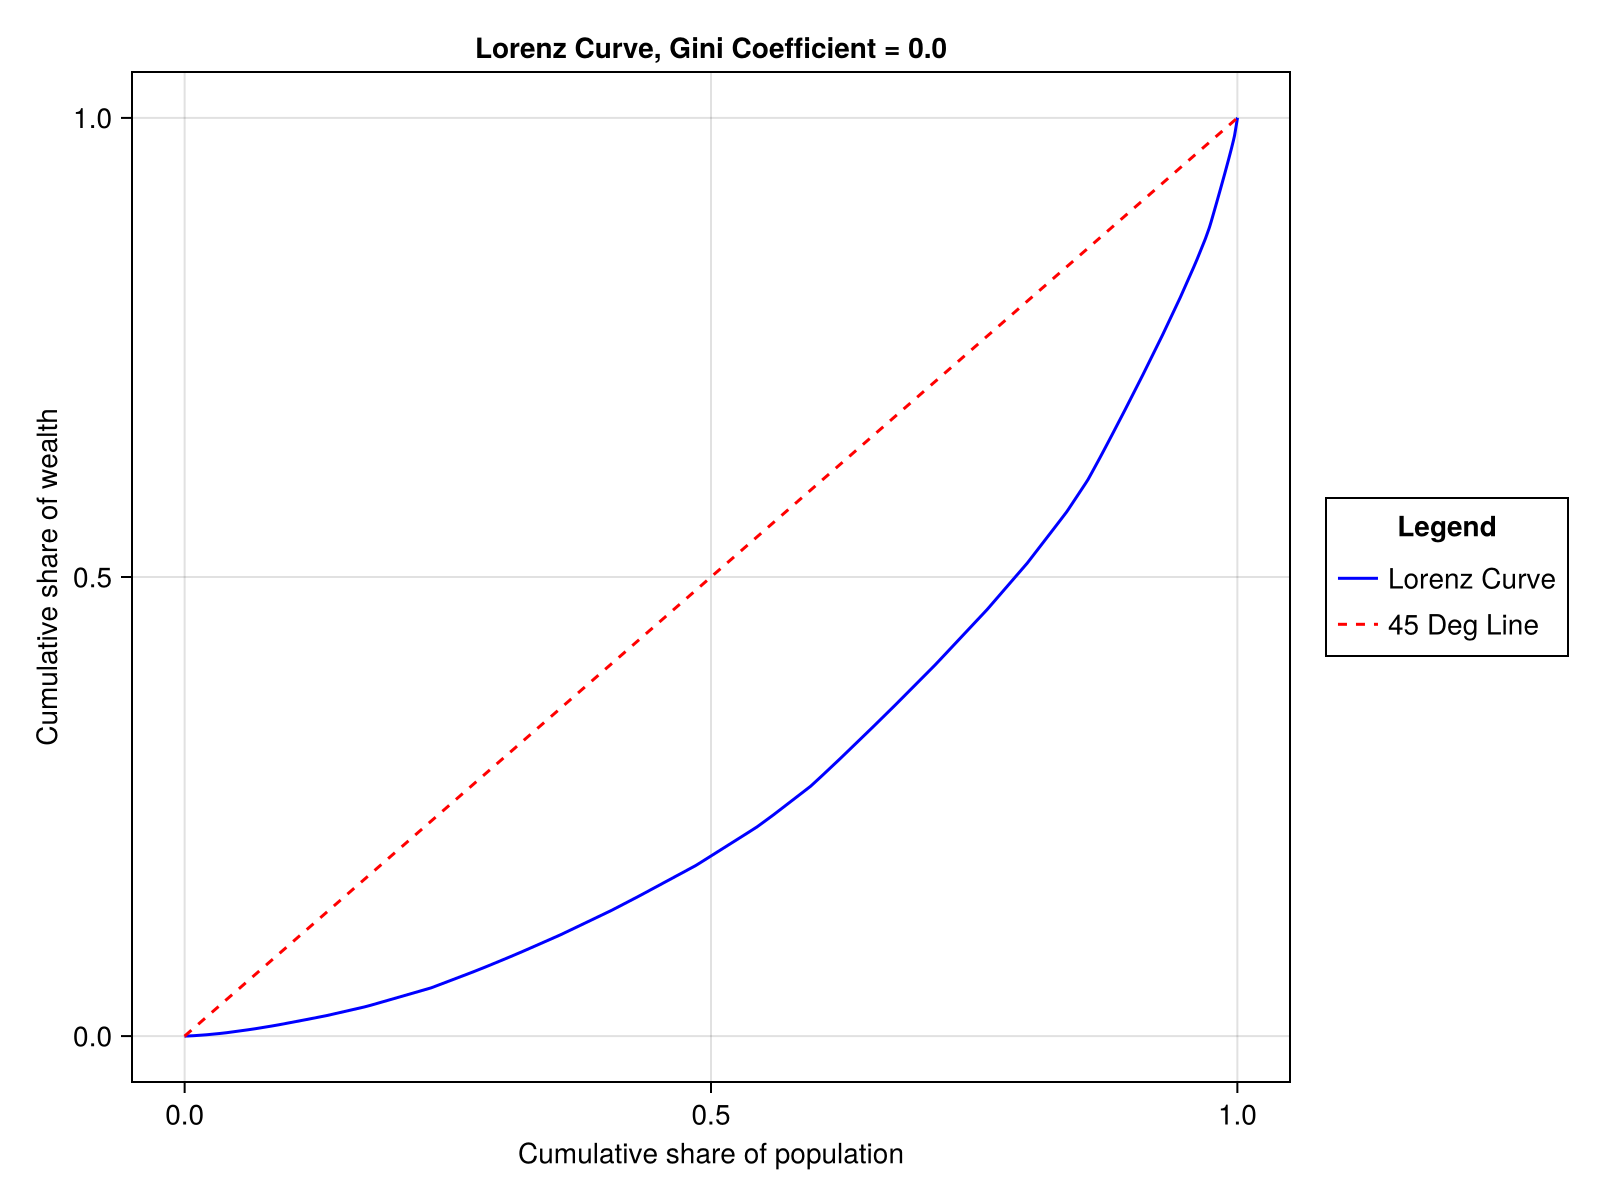

In [49]:
function gini_coeff(distribution, wealth, pars)
    (; na, nz) = pars
    n = na * nz
    gini_w = zeros(n)
    gini_dist = zeros(n)
    lorenz = zeros(n)
    wealth = reshape(wealth, n)
    distribution = reshape(distribution, n)
    sorted_wealth = sort(wealth, rev = false)
    sorted_indices = sortperm(wealth)
    sorted_distribution = distribution[sorted_indices]
    for i in 1:n
        gini_w[i] = sorted_wealth[i] * sorted_distribution[i]
        if i == 1
            lorenz[i] = gini_w[i]
            gini_dist[i] = sorted_distribution[i]
        else
            lorenz[i] = lorenz[i-1] + gini_w[i]
            gini_dist[i] = gini_dist[i-1] + sorted_distribution[i]
        end
    end
    lorenz = lorenz / lorenz[end]
    spline = Spline1D(gini_dist, lorenz, k=1)
    test = evaluate(spline, 0.3)
    Gini = mc(spline, n)
    Gini_round = round(Gini, digits = 4)
    fig = Figure(size = (800, 600))
    ax = Axis(fig[1, 1], xlabel = "Cumulative share of population", ylabel = "Cumulative share of wealth", title = "Lorenz Curve, Gini Coefficient = $Gini_round")
    lines!(ax, gini_dist, lorenz, color = :blue, label = "Lorenz Curve")
    lines!(ax, gini_dist, gini_dist, color = :red, linestyle = :dash, label = "45 Deg Line")
    legend = Legend(fig[1,2], ax, "Legend", orientation = :vertical, fontsize = 4)
    return fig
end

gini_coeff(dist_vfi_crra, wealth_vfi_crra, pars_crra)